In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import torchvision
import torch.optim as optim
import matplotlib.pyplot as plt
#from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, models, utils
from tqdm import tqdm
import os
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image

In [2]:
class SparseConv(nn.Module):

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size):
        super().__init__()

        padding = kernel_size//2

        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            padding=padding,
            bias=False)

        self.bias = nn.Parameter(
            torch.zeros(out_channels), 
            requires_grad=True)

        self.sparsity = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            padding=padding,
            bias=False)

        #######
        kernel = torch.FloatTensor(torch.ones([kernel_size, kernel_size])).unsqueeze(0).unsqueeze(0)

        self.sparsity.weight = nn.Parameter(
            data=kernel, 
            requires_grad=False)

        self.relu = nn.ReLU(inplace=True)

        # define a two by two max-pooling layer inside the block
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.norm = nn.BatchNorm2d(out_channels)

        

    def forward(self, x, mask):
        x = x*mask
        x = self.conv(x)
        normalizer = 1/(self.sparsity(mask)+1e-8)
        x = x * normalizer + self.bias.unsqueeze(0).unsqueeze(2).unsqueeze(3)
        x = self.norm(x)
        x = self.relu(x)
        x = self.max_pool(x)
    
        
        mask = self.max_pool(mask)

        return x, mask


class SparseConvNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.SparseLayer1 = SparseConv(3, 16, 11)
        self.SparseLayer2 = SparseConv(16, 16, 7)
        self.SparseLayer3 = SparseConv(16, 16, 5)
        self.SparseLayer4 = SparseConv(16, 16, 3)
        self.Flatten = nn.Flatten()
        self.fc1 = nn.Linear(16*14*14, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 101)
        self.drop = nn.Dropout(p = 0.2)

    def forward(self, x, mask):
        x, mask = self.SparseLayer1(x, mask)
        x, mask = self.SparseLayer2(x, mask)
        x, mask = self.SparseLayer3(x, mask)
        x, mask = self.SparseLayer4(x, mask)
        x = self.Flatten(x)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        # x = self.drop(x)
        x = self.fc3(x)
        # x = self.drop(x)

        return x


class ConvNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 11, padding="same")
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 16, 7, padding="same")
        self.conv3 = nn.Conv2d(16, 16, 5, padding="same")
        self.conv4 = nn.Conv2d(16, 16, 3, padding="same")
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 101)

    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = self.max_pool(x)
        x = F.relu(self.conv2(x))
        x = self.max_pool(x)
        x = F.relu(self.conv3(x))
        x = self.max_pool(x)
        x = F.relu(self.conv4(x))
        x = self.max_pool(x)
        x = self.Flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


In [3]:
# custom dataset class

class CustomDataset(Dataset):
    def __init__(self, images, labels, mask):
        self.labels = labels
        self.images = images
        self.mask = mask
        for i in range(len(self.images)):
            self.images[i] = self.images[i] * self.mask[i]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        
        return self.images[index].reshape((3,224,224)), self.labels[index], self.mask[index].reshape((1,224,224))


In [4]:
def train(train_loader, model, optimizer, criterion, device):
    """
    Trains network for one epoch in batches.

    Args:
        train_loader: Data loader for training set.
        model: Neural network model.
        optimizer: Optimizer (e.g. SGD).
        criterion: Loss function (e.g. cross-entropy loss).
        device: whether the network runs on cpu or gpu
    """

    avg_loss = 0
    correct = 0
    total = 0

    # Switch to train mode
    model.train()

    # Iterate through batches
    for i, data in enumerate(train_loader):
        '''
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        '''
        ######
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels, mask = data

        # Move data to target device
        inputs, labels, mask = inputs.to(device), labels.to(device), mask.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        # Forward propagation
        outputs = model(inputs, mask)

        # Loss computation
        loss = (criterion(outputs, labels) * mask.detach()).sum() / mask.sum()
        ######

        loss.backward()
        optimizer.step()

        # Keep track of loss and accuracy
        avg_loss += loss
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return avg_loss / len(train_loader), 100 * correct / total



In [5]:
def test(test_loader, model, criterion, device):
    """
    Evaluates network in batches.

    Args:
        test_loader: Data loader for test set.
        model: Neural network model.
        criterion: Loss function (e.g. cross-entropy loss).
    """

    avg_loss = 0
    correct = 0
    total = 0

    # Switch to test mode
    model.eval()

    # Use torch.no_grad to skip gradient calculation, not needed for evaluation
    with torch.no_grad():
        # Iterate through batches
        for data in test_loader:
            '''
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            '''
            ######
            # Get the inputs; data is a list of [inputs, labels]
            inputs, labels, mask = data

            # Move data to target device
            inputs, labels, mask = inputs.to(device), labels.to(device), mask.to(device)

            # Forward + backward + optimize
            # Forward propagation
            outputs = model(inputs, mask)

            # Loss computation
            loss = (criterion(outputs, labels) * mask.detach()).sum() / mask.sum()
            ######

            # Keep track of loss and accuracy
            avg_loss += loss
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return avg_loss / len(test_loader), 100 * correct / total

In [6]:
def validation(validation_loader, model, criterion, device):
    """
    Evaluates network in batches.

    Args:
        test_loader: Data loader for test set.
        model: Neural network model.
        criterion: Loss function (e.g. cross-entropy loss).
    """

    avg_loss = 0
    correct = 0
    total = 0

    # Switch to test mode
    model.eval()

    # Use torch.no_grad to skip gradient calculation, not needed for evaluation
    with torch.no_grad():
        # Iterate through batches
        for data in validation_loader:
            '''
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            '''
            ######
            # Get the inputs; data is a list of [inputs, labels]
            inputs, labels, mask = data

            # Move data to target device
            inputs, labels, mask = inputs.to(device), labels.to(device), mask.to(device)

            # Forward + backward + optimize
            # Forward propagation
            outputs = model(inputs, mask)

            # Loss computation
            loss = (criterion(outputs, labels) * mask.detach()).sum() / mask.sum()
            ######

            # Keep track of loss and accuracy
            avg_loss += loss
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return avg_loss / len(validation_loader), 100 * correct / total

In [7]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
mps_avail = torch.backends.mps.is_available()
print(f"Is the mps available? {mps_avail}")
print(device)

Is the mps available? True
mps


8611


/var/folders/pw/g2x0j2h521j60j5jvft9gmwc0000gn/T/ipykernel_43481/2769842677.py:93: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


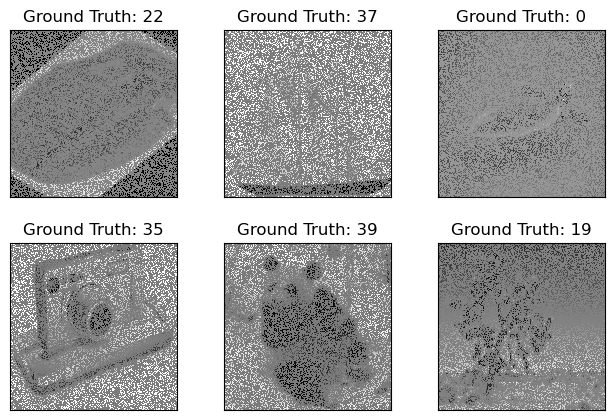

  7%|▋         | 1/15 [00:13<03:13, 13.79s/it]


Training set: Epoch: 0, Avg. loss: 3.7168, Accuracy: 22.9764%)

Validation set: Epoch: 0, Avg. loss: 4.5297, Accuracy: 2.3222%)

Test set: Epoch: 0, Avg. loss: 4.6533, Accuracy: 2.3215%)


 13%|█▎        | 2/15 [00:43<05:01, 23.20s/it]


Training set: Epoch: 1, Avg. loss: 3.0641, Accuracy: 33.5753%)

Validation set: Epoch: 1, Avg. loss: 2.8933, Accuracy: 35.8491%)

Test set: Epoch: 1, Avg. loss: 3.6144, Accuracy: 35.0551%)


 20%|██        | 3/15 [01:20<05:55, 29.63s/it]


Training set: Epoch: 2, Avg. loss: 2.6165, Accuracy: 40.3811%)

Validation set: Epoch: 2, Avg. loss: 2.5700, Accuracy: 42.1626%)

Test set: Epoch: 2, Avg. loss: 2.8554, Accuracy: 41.6135%)


 27%|██▋       | 4/15 [02:43<09:16, 50.61s/it]


Training set: Epoch: 3, Avg. loss: 2.2634, Accuracy: 47.1325%)

Validation set: Epoch: 3, Avg. loss: 2.3457, Accuracy: 45.5733%)

Test set: Epoch: 3, Avg. loss: 1.9178, Accuracy: 46.3146%)


 33%|███▎      | 5/15 [04:21<11:14, 67.48s/it]


Training set: Epoch: 4, Avg. loss: 1.9936, Accuracy: 52.9946%)

Validation set: Epoch: 4, Avg. loss: 2.1720, Accuracy: 49.7097%)

Test set: Epoch: 4, Avg. loss: 1.9035, Accuracy: 48.9263%)


 40%|████      | 6/15 [05:53<11:22, 75.83s/it]


Training set: Epoch: 5, Avg. loss: 1.7064, Accuracy: 57.8947%)

Validation set: Epoch: 5, Avg. loss: 2.0539, Accuracy: 52.2496%)

Test set: Epoch: 5, Avg. loss: 2.0912, Accuracy: 52.3506%)


 47%|████▋     | 7/15 [07:15<10:23, 77.91s/it]


Training set: Epoch: 6, Avg. loss: 1.4724, Accuracy: 61.5608%)

Validation set: Epoch: 6, Avg. loss: 1.9660, Accuracy: 54.2816%)

Test set: Epoch: 6, Avg. loss: 2.7466, Accuracy: 53.1050%)


 53%|█████▎    | 8/15 [08:45<09:32, 81.81s/it]


Training set: Epoch: 7, Avg. loss: 1.2382, Accuracy: 69.1652%)

Validation set: Epoch: 7, Avg. loss: 2.0137, Accuracy: 52.5399%)

Test set: Epoch: 7, Avg. loss: 2.5034, Accuracy: 53.3372%)


 60%|██████    | 9/15 [10:07<08:11, 81.96s/it]


Training set: Epoch: 8, Avg. loss: 1.1590, Accuracy: 69.7096%)

Validation set: Epoch: 8, Avg. loss: 2.0010, Accuracy: 54.7170%)

Test set: Epoch: 8, Avg. loss: 3.3042, Accuracy: 54.3239%)


 67%|██████▋   | 10/15 [11:27<06:46, 81.25s/it]


Training set: Epoch: 9, Avg. loss: 0.9287, Accuracy: 75.6443%)

Validation set: Epoch: 9, Avg. loss: 1.9108, Accuracy: 57.5472%)

Test set: Epoch: 9, Avg. loss: 2.8927, Accuracy: 57.3418%)


 73%|███████▎  | 11/15 [12:55<05:33, 83.50s/it]


Training set: Epoch: 10, Avg. loss: 0.7502, Accuracy: 79.0381%)

Validation set: Epoch: 10, Avg. loss: 1.8455, Accuracy: 60.1597%)

Test set: Epoch: 10, Avg. loss: 2.8039, Accuracy: 57.7481%)


 80%|████████  | 12/15 [14:21<04:12, 84.21s/it]


Training set: Epoch: 11, Avg. loss: 0.5255, Accuracy: 86.2250%)

Validation set: Epoch: 11, Avg. loss: 1.9060, Accuracy: 58.4180%)

Test set: Epoch: 11, Avg. loss: 4.4388, Accuracy: 56.9356%)


 87%|████████▋ | 13/15 [15:47<02:49, 84.73s/it]


Training set: Epoch: 12, Avg. loss: 0.4409, Accuracy: 88.7477%)

Validation set: Epoch: 12, Avg. loss: 1.8788, Accuracy: 60.9579%)

Test set: Epoch: 12, Avg. loss: 2.6182, Accuracy: 58.3865%)


 93%|█████████▎| 14/15 [17:24<01:28, 88.22s/it]


Training set: Epoch: 13, Avg. loss: 0.3739, Accuracy: 89.7459%)

Validation set: Epoch: 13, Avg. loss: 1.9966, Accuracy: 59.6517%)

Test set: Epoch: 13, Avg. loss: 2.8772, Accuracy: 59.2571%)


100%|██████████| 15/15 [18:46<00:00, 75.08s/it]


Training set: Epoch: 14, Avg. loss: 0.2511, Accuracy: 93.6116%)

Validation set: Epoch: 14, Avg. loss: 1.9447, Accuracy: 60.3048%)

Test set: Epoch: 14, Avg. loss: 2.4968, Accuracy: 59.1410%)

Finished.


In [8]:
# from torchsummary import summary

# from SparseConvNet import SparseConvNet, ConvNet
# from train import train
# from validation import validation
# from test import test
# from dataset_caltech import CustomDataset

# hyperparameters
validation_ratio = 0.2
test_ratio = 0.2
n_epochs = 15
batch_size_train = 128 #64
batch_size_valid = int(np.round(8611*(1-test_ratio)*validation_ratio))
batch_size_test = int(np.round(8611*test_ratio))
learning_rate = 0.001
# learning_rate = 0.005
weight_decay = 1e-3 # 1e-3
# momentum = 0.5
log_interval = 10

random_seed = 44
torch.manual_seed(random_seed)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed(random_seed)
#     torch.cuda.manual_seed_all(random_seed)
# np.random.seed(random_seed)

# device
#device = 'cuda' if torch.cuda.is_available() else 'cpu'

image_path = '/Users/mac/Documents/FILES/TUDelft/Q3/Deep Learning/Project/caltech/caltech-101/101_ObjectCategories'

label_list = os.listdir(image_path)
label_list = [item for item in label_list if item != 'BACKGROUND_Google']
label_path = [image_path + '/' + item for item in label_list]
label_path = label_path[1:-1]

transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])]
)

images = []
labels = []

for i in range(len(label_path)):
    folder_path = label_path[i]
    if folder_path == '/Users/mac/Documents/FILES/TUDelft/Q3/Deep Learning/Project/caltech/caltech-101/101_ObjectCategories/.DS_Store':
        continue
    # for folder_path in label_path:
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        # print(file_path)
        if filename.endswith('.jpg') or filename.endswith('.jpeg'):
            img = Image.open(file_path)
            if img.mode != 'RGB':
                img = img.convert('RGB')
            img_transformed = transform(img)
            images.append(img_transformed)
            labels.append(i)

labels = torch.tensor(labels)
print(len(images))
x_train_validation, x_test, y_train_validation, y_test = train_test_split(images, labels, 
                                                                          test_size=test_ratio, stratify=labels, random_state=42)
x_train, x_validation, y_train, y_validation = train_test_split(x_train_validation, y_train_validation, 
                                                                test_size=validation_ratio, stratify=y_train_validation, random_state=42)

# generate random masks, to be modified!
sparsity_level = 0.7 #0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7
train_mask = torch.bernoulli(torch.full(torch.Size([len(x_train),224,224]), 1 - sparsity_level))
validation_mask = torch.bernoulli(torch.full(torch.Size([len(x_validation),224,224]), 1 - sparsity_level))
test_mask = torch.bernoulli(torch.full(torch.Size([len(x_test),224,224]), 1 - sparsity_level))

train_data = CustomDataset(x_train, y_train, train_mask)
validation_data = CustomDataset(x_validation, y_validation, validation_mask)
test_data = CustomDataset(x_test, y_test, test_mask)

trainLoader = DataLoader(train_data, batch_size=batch_size_train, shuffle=True)
validationLoader = DataLoader(validation_data, batch_size=batch_size_valid, shuffle=False)
testLoader = DataLoader(test_data, batch_size=batch_size_test, shuffle=False)

# draw some examples
examples = enumerate(testLoader)
batch_idx, (example_data, example_targets, example_mask) = next(examples)

fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()


# Create a writer to write to Tensorboard
# writer = SummaryWriter()

# Create classifier model
# model = ConvNet()
model = SparseConvNet()

# Create loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# Use GPU if available
model = model.to(device)


train_losses = []
train_accuracy = []
train_counter = []
validation_losses = []
validation_accuracy = []
test_losses = []
test_accuracy = []
#test_counter = [i * len(train_loader.dataset) for i in range(n_epochs + 1)]

for epoch in tqdm(range(n_epochs)):
    # Train on data
    train_loss, train_acc = train(trainLoader, model, optimizer, criterion, device)
    train_losses.append(train_loss)
    train_accuracy.append(train_acc)

    validation_loss, validation_acc = validation(validationLoader, model, criterion, device)
    validation_losses.append(validation_loss)
    validation_accuracy.append(validation_acc)
    
    test_loss, test_acc = test(testLoader, model, criterion, device)
    test_losses.append(test_loss)
    test_accuracy.append(test_acc)

    print('\nTraining set: Epoch: {:.0f}, Avg. loss: {:.4f}, Accuracy: {:.4f}%)'.format(
        epoch, train_loss, train_acc))
    print('\nValidation set: Epoch: {:.0f}, Avg. loss: {:.4f}, Accuracy: {:.4f}%)'.format(
        epoch, validation_loss, validation_acc))
    print('\nTest set: Epoch: {:.0f}, Avg. loss: {:.4f}, Accuracy: {:.4f}%)'.format(
        epoch, test_loss, test_acc))

# Test on data
# test_loss, test_acc = test(testLoader, model, criterion, device)
# print('\nTest set: Epoch: {:.0f}, Avg. loss: {:.4f}, Accuracy: {:.4f}%)'.format(
#         epoch, test_loss, test_acc))

print('\nFinished.')

In [14]:
test_accuracy_sparse07 = np.load('/Users/mac/Documents/FILES/TUDelft/Q3/Deep Learning/Project/caltech/results/test_accuracy_sparse07.npy')
test_accuracy_sparse07[-1]

59.14103308183401

In [9]:
for i in range(len(train_losses)):
    train_losses[i] = train_losses[i].cpu().detach().numpy()
    validation_losses[i] = validation_losses[i].cpu().detach().numpy()
    test_losses[i] = test_losses[i].cpu().detach().numpy()

In [10]:
folder_path = 'results'
os.makedirs(folder_path, exist_ok=True)

In [11]:
# train_losses.append(train_loss)
# train_accuracy.append(train_acc)

file_path = os.path.join(folder_path, 'train_losses_sparse07.npy')
np.save(file_path, train_losses)
file_path = os.path.join(folder_path, 'train_accuracy_sparse07.npy')
np.save(file_path, train_accuracy)

file_path = os.path.join(folder_path, 'validation_losses_sparse07.npy')
np.save(file_path, validation_losses)
file_path = os.path.join(folder_path, 'validation_accuracy_sparse07.npy')
np.save(file_path, validation_accuracy)

file_path = os.path.join(folder_path, 'test_losses_sparse07.npy')
np.save(file_path, test_losses)
file_path = os.path.join(folder_path, 'test_accuracy_sparse07.npy')
np.save(file_path, test_accuracy)

63.029599535693556


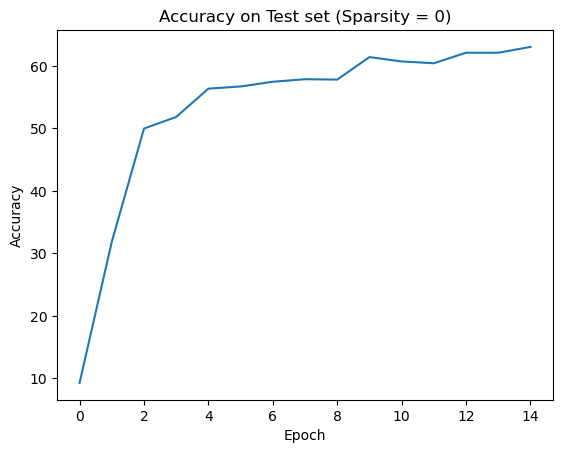

In [22]:
plt.plot(test_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy on Test set (Sparsity = 0)')
print(test_acc)